In [1]:
import os
import cv2
from ultralytics import YOLO
import matplotlib.pyplot as plt
import random
import shutil

In [2]:
def run_prediction(model, to_annotate_folder):
    # Use the model to make predictions
    auto_annotation = model.predict(source=to_annotate_folder, save=True)

    # Initialize counters for each category
    counts = {
        "less_than_30": 0,
        "equal_30": 0,
        "equal_31": 0,
        "equal_32": 0,
        "greater_than_32": 0,
    }

    # Count the number of bounding boxes for each image
    for result in auto_annotation:
        num_boxes = len(result.boxes.xyxy)  # Count the number of bounding boxes

        if num_boxes < 30:
            counts["less_than_30"] += 1
        elif num_boxes == 30:
            counts["equal_30"] += 1
        elif num_boxes == 31:
            counts["equal_31"] += 1
        elif num_boxes == 32:
            counts["equal_32"] += 1
        elif num_boxes > 32:
            counts["greater_than_32"] += 1

    # Display the counting results
    print("Summary of Bounding Box Counts:")
    for key, value in counts.items():
        print(
            f"Number of images with bounding boxes {key.replace('_', ' ').capitalize()}: {value}"
        )

    return auto_annotation

In [3]:
def manual_quality_control(auto_annotation_sample):
    for result in auto_annotation_sample:
        img_path = result.path
        original_image = cv2.imread(img_path)

        if result.boxes and len(result.boxes.xyxy) > 0:
            print(f"Detected boxes in {img_path}: {len(result.boxes.xyxy)}")

            for box in result.boxes.xyxy:
                if len(box) == 4:
                    x1, y1, x2, y2 = box
                    conf = None
                    cls = None
                elif len(box) == 6:
                    x1, y1, x2, y2, conf, cls = box

                label = (
                    f"Class: {int(cls)}, Conf: {conf:.2f}"
                    if conf is not None and cls is not None
                    else ""
                )
                cv2.rectangle(
                    original_image,
                    (int(x1), int(y1)),
                    (int(x2), int(y2)),
                    (0, 255, 0),
                    2,
                )
                if label:
                    cv2.putText(
                        original_image,
                        label,
                        (int(x1), int(y1) - 10),
                        cv2.FONT_HERSHEY_SIMPLEX,
                        0.5,
                        (0, 255, 0),
                        2,
                    )
        else:
            print(f"No boxes detected in {img_path}")

        # Display the image
        plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
        plt.axis("off")
        plt.title(f"Predictions for {os.path.basename(img_path)}")
        plt.show()

In [4]:
def save_prediction_results(
    auto_annotation_sample, bbox_output_folder, annotated_images_folder
):
    # Create folders if they do not exist
    os.makedirs(bbox_output_folder, exist_ok=True)
    os.makedirs(annotated_images_folder, exist_ok=True)

    for result in auto_annotation_sample:
        img_path = result.path  # Get the image path

        # Get the original image for annotation
        original_image = cv2.imread(img_path)

        # Prepare file name to save bounding boxes
        bbox_output_filename = os.path.join(
            bbox_output_folder,
            f"bboxes_{os.path.splitext(os.path.basename(img_path))[0]}.txt",
        )

        with open(bbox_output_filename, "w") as bbox_file:
            # Check if any bounding boxes were detected
            if result.boxes and len(result.boxes.xyxy) > 0:
                for box in result.boxes.xyxy:
                    if len(box) == 4:
                        x1, y1, x2, y2 = box
                        conf = None
                        cls = None
                    elif len(box) == 6:
                        x1, y1, x2, y2, conf, cls = box

                    # Save bounding box information to the file
                    if cls is not None and conf is not None:
                        bbox_file.write(f"{int(cls)} {x1} {y1} {x2} {y2} {conf:.4f}\n")
                    else:
                        # If there is no class or confidence, save default information
                        bbox_file.write(f"Unknown {x1} {y1} {x2} {y2}\n")

                    # Draw bounding box on the image
                    cv2.rectangle(
                        original_image,
                        (int(x1), int(y1)),
                        (int(x2), int(y2)),
                        (0, 255, 0),
                        2,
                    )
                    if conf is not None and cls is not None:
                        label = f"Class: {int(cls)}, Conf: {conf:.2f}"
                        cv2.putText(
                            original_image,
                            label,
                            (int(x1), int(y1) - 10),
                            cv2.FONT_HERSHEY_SIMPLEX,
                            0.5,
                            (0, 255, 0),
                            2,
                        )

                # Save the annotated image with bounding boxes
                annotated_image_output = os.path.join(
                    annotated_images_folder, f"annotated_{os.path.basename(img_path)}"
                )
                cv2.imwrite(annotated_image_output, original_image)
            else:
                bbox_file.write("No boxes detected\n")  # Note if no boxes were detected
    print("complete save")

In [5]:
model = YOLO("../models/yolo8s-100.pt")
to_annotate_folder = "../data/images"
auto_annotation_sample = run_prediction(model, to_annotate_folder)


image 1/5 d:\Code\ktp-text-recog\notebook\..\data\images\ktp-image-174.jpg: 352x640 31 class_names, 96.6ms
image 2/5 d:\Code\ktp-text-recog\notebook\..\data\images\ktp-image-176.jpg: 352x640 31 class_names, 112.4ms
image 3/5 d:\Code\ktp-text-recog\notebook\..\data\images\ktp-image-177.jpg: 352x640 31 class_names, 80.5ms
image 4/5 d:\Code\ktp-text-recog\notebook\..\data\images\ktp-image-178.jpg: 352x640 33 class_names, 82.7ms
image 5/5 d:\Code\ktp-text-recog\notebook\..\data\images\ktp-image-180.jpg: 352x640 32 class_names, 75.9ms
Speed: 1.8ms preprocess, 89.6ms inference, 1.0ms postprocess per image at shape (1, 3, 352, 640)
Results saved to d:\Code\ktp-text-recog\runs\detect\predict14
Ringkasan Jumlah Bounding Box:
Jumlah gambar dengan bounding box Less than 30: 0
Jumlah gambar dengan bounding box Equal 30: 0
Jumlah gambar dengan bounding box Equal 31: 3
Jumlah gambar dengan bounding box Equal 32: 1
Jumlah gambar dengan bounding box Greater than 32: 1


Detected boxes in d:\Code\ktp-text-recog\notebook\..\data\images\ktp-image-174.jpg: 31


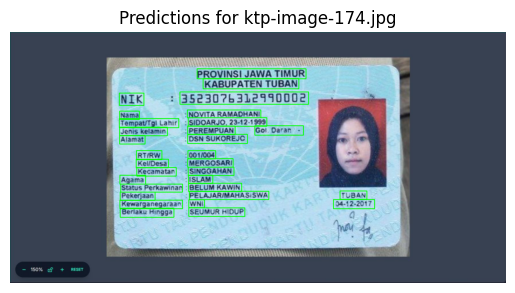

Detected boxes in d:\Code\ktp-text-recog\notebook\..\data\images\ktp-image-176.jpg: 31


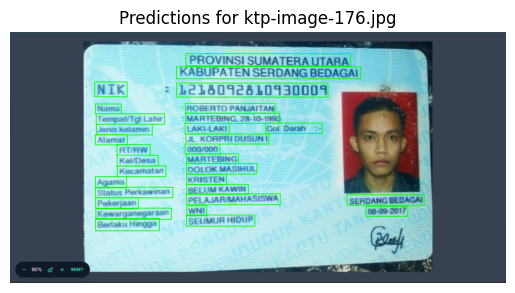

Detected boxes in d:\Code\ktp-text-recog\notebook\..\data\images\ktp-image-177.jpg: 31


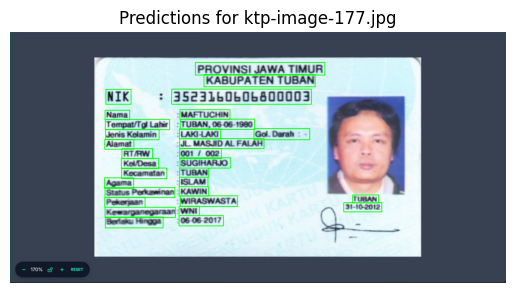

Detected boxes in d:\Code\ktp-text-recog\notebook\..\data\images\ktp-image-178.jpg: 33


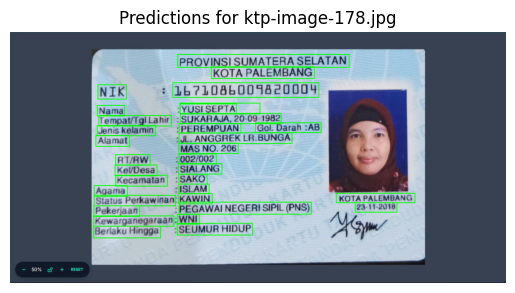

Detected boxes in d:\Code\ktp-text-recog\notebook\..\data\images\ktp-image-180.jpg: 32


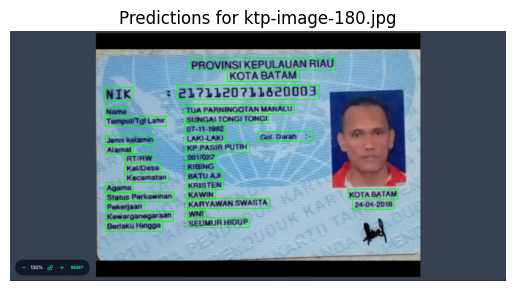

In [6]:
manual_quality_control(auto_annotation_sample)

In [7]:
output_annotation = "../data/auto-annotations/"
bbox_output = "../data/auto-annotations/"
image_anno = "../data/results-auto-annotations/"
save_prediction_results(
    auto_annotation_sample,
    bbox_output_folder=bbox_output,
    annotated_images_folder=image_anno,
)

complete save


In [8]:
def crop_images(auto_annotation_sample, base_output_folder):
    # Create base folder for saving cropped images
    os.makedirs(base_output_folder, exist_ok=True)

    for result in auto_annotation_sample:
        img_path = result.path  # Get the image path
        original_image = cv2.imread(img_path)  # Read the original image

        cropped_images = []  # List to store cropped images
        titles = []  # List to store titles for each cropped image

        # Create name for the folder for this image
        image_folder_name = os.path.splitext(os.path.basename(img_path))[
            0
        ]  # Remove file extension
        output_crop_folder = os.path.join(
            base_output_folder, f"cropped-{image_folder_name}"
        )
        os.makedirs(
            output_crop_folder, exist_ok=True
        )  # Create folder for cropped images

        # Check if any bounding boxes were detected
        if result.boxes and len(result.boxes.xyxy) > 0:
            for idx, box in enumerate(result.boxes.xyxy):
                if len(box) == 4:
                    x1, y1, x2, y2 = box
                    conf = None
                    cls = None
                elif len(box) == 6:
                    x1, y1, x2, y2, conf, cls = box

                # Calculate and perform cropping
                cropped_image = original_image[int(y1) : int(y2), int(x1) : int(x2)]
                cropped_images.append(cropped_image)  # Save cropped image
                label = (
                    f"Box {idx + 1} - Class: {cls}, Conf: {conf:.2f}"
                    if conf is not None
                    else f"Box {idx + 1} - No label"
                )
                titles.append(label)

                # Save the cropped image to the generated folder
                cropped_output_filename = os.path.join(
                    output_crop_folder, f"box{idx + 1}.jpg"
                )
                cv2.imwrite(cropped_output_filename, cropped_image)
        else:
            print(f"No boxes detected for {img_path}. Skipping cropping.")

        # Display images in grid format
        if cropped_images:
            num_cropped_images = len(cropped_images)
            cols = 10
            rows = num_cropped_images // cols + (
                num_cropped_images % cols > 0
            )  # Calculate number of rows
            fig, axs = plt.subplots(
                rows, cols, figsize=(20, rows * 2)
            )  # Set a larger size for clear images
            axs = axs.ravel()  # Flatten the 2D array to 1D for easier processing

            for i in range(rows * cols):
                if i < num_cropped_images:
                    axs[i].imshow(cv2.cvtColor(cropped_images[i], cv2.COLOR_BGR2RGB))
                    axs[i].set_title(titles[i])
                else:
                    axs[i].axis("off")  # Turn off axis for extra images

            plt.tight_layout()  # Adjust layout to avoid overlap
            plt.show()  # Display images
            plt.tight_layout()  # Adjust layout to avoid overlap
            plt.show()  # Display images
            plt.show()  # Display images

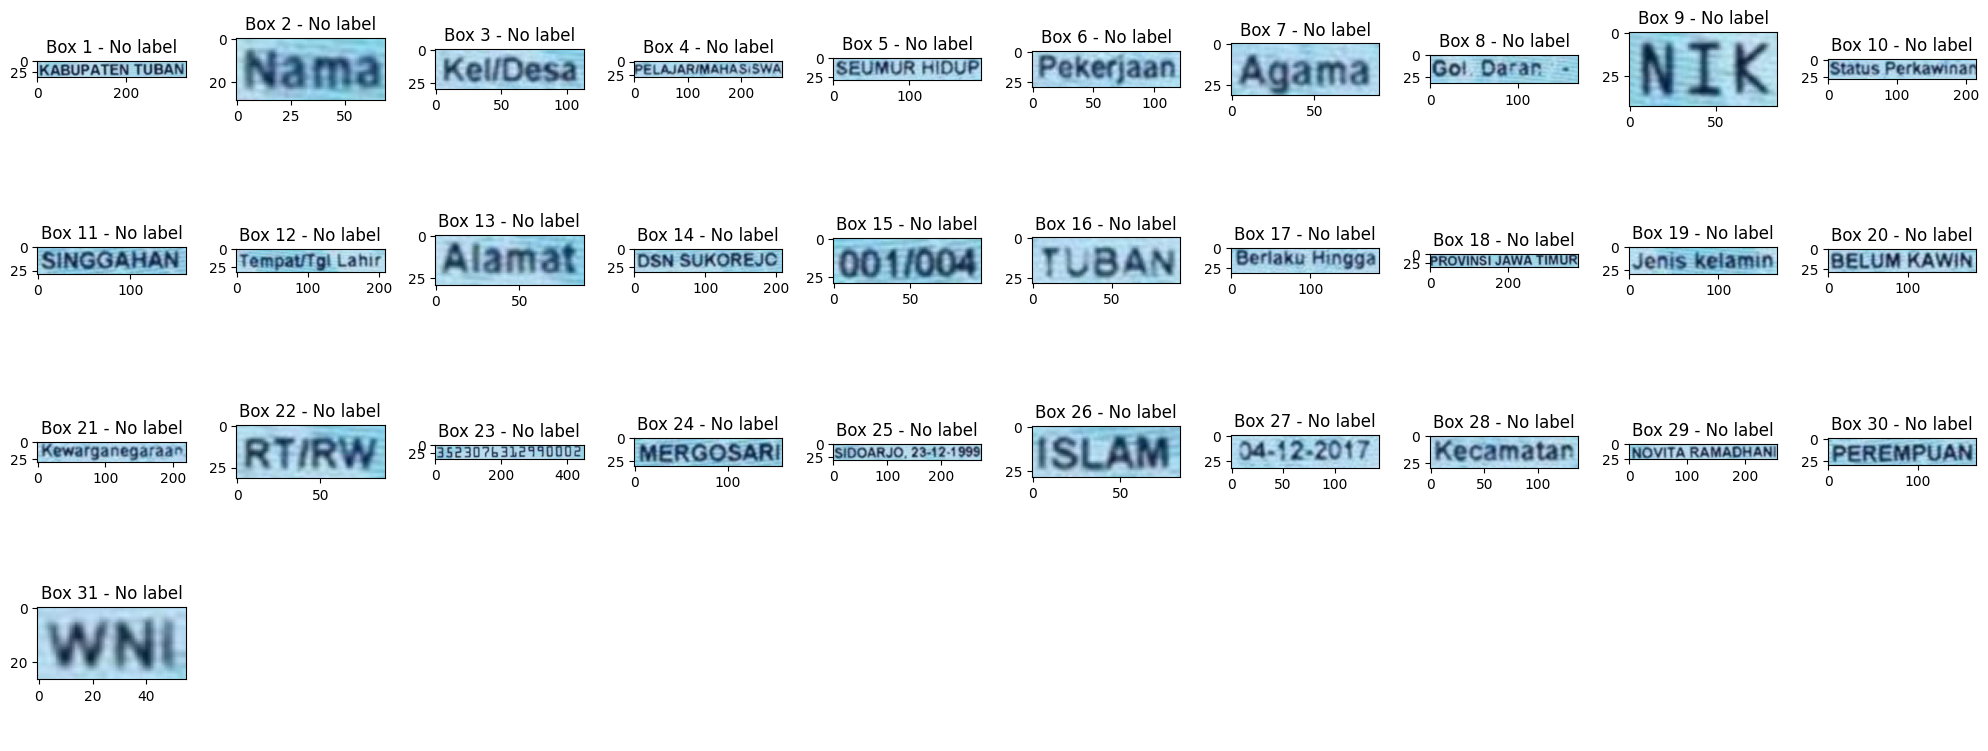

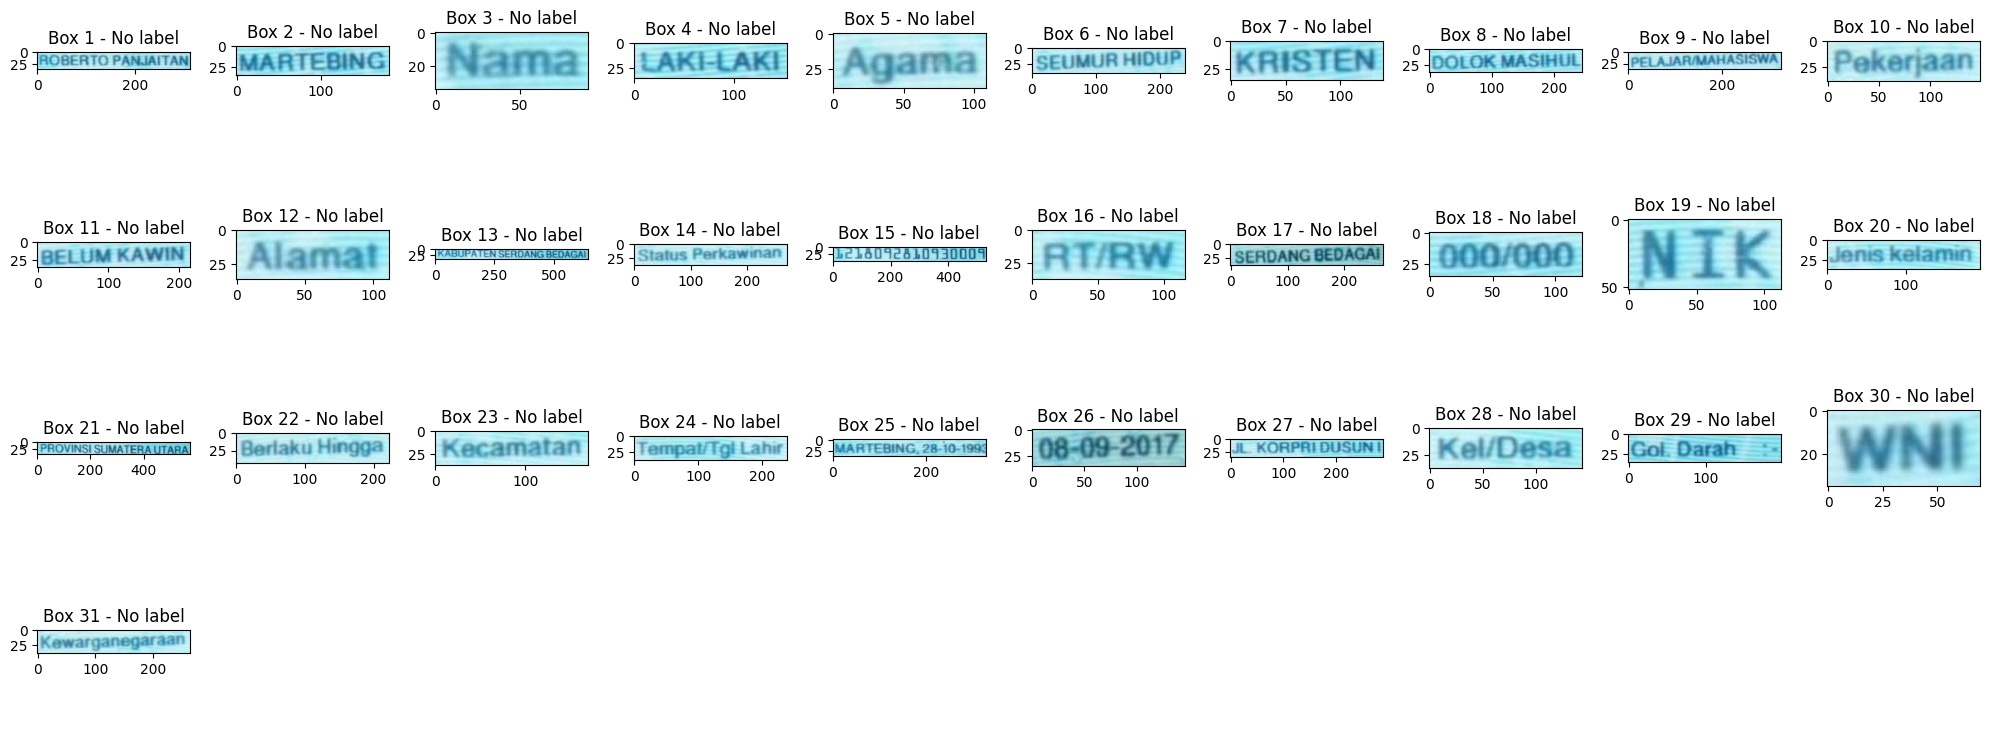

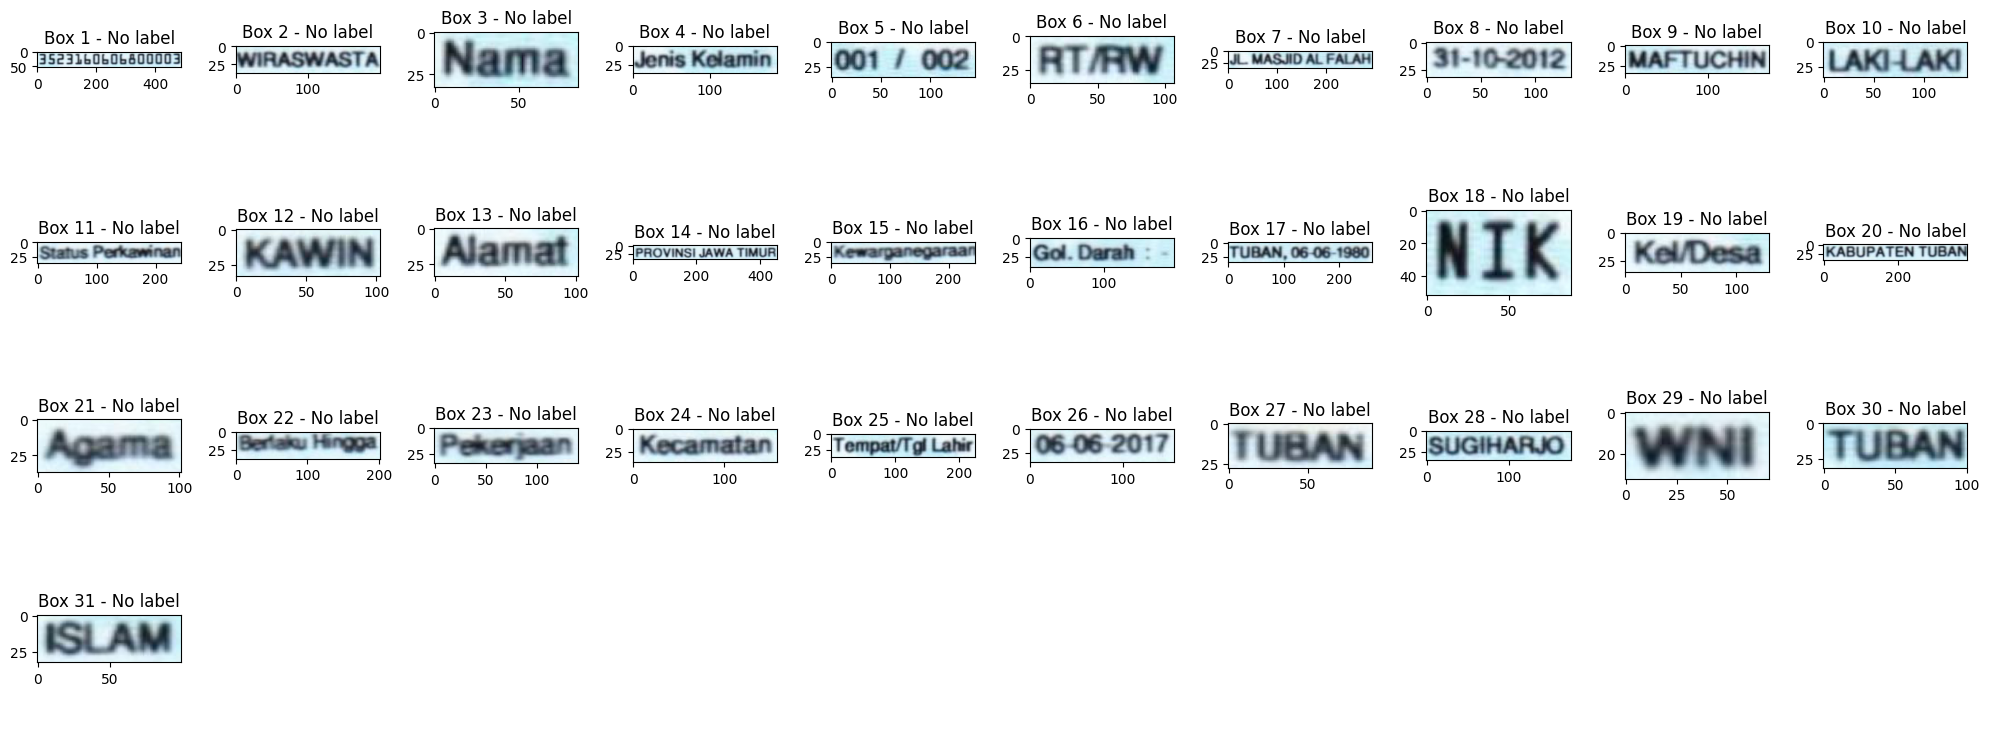

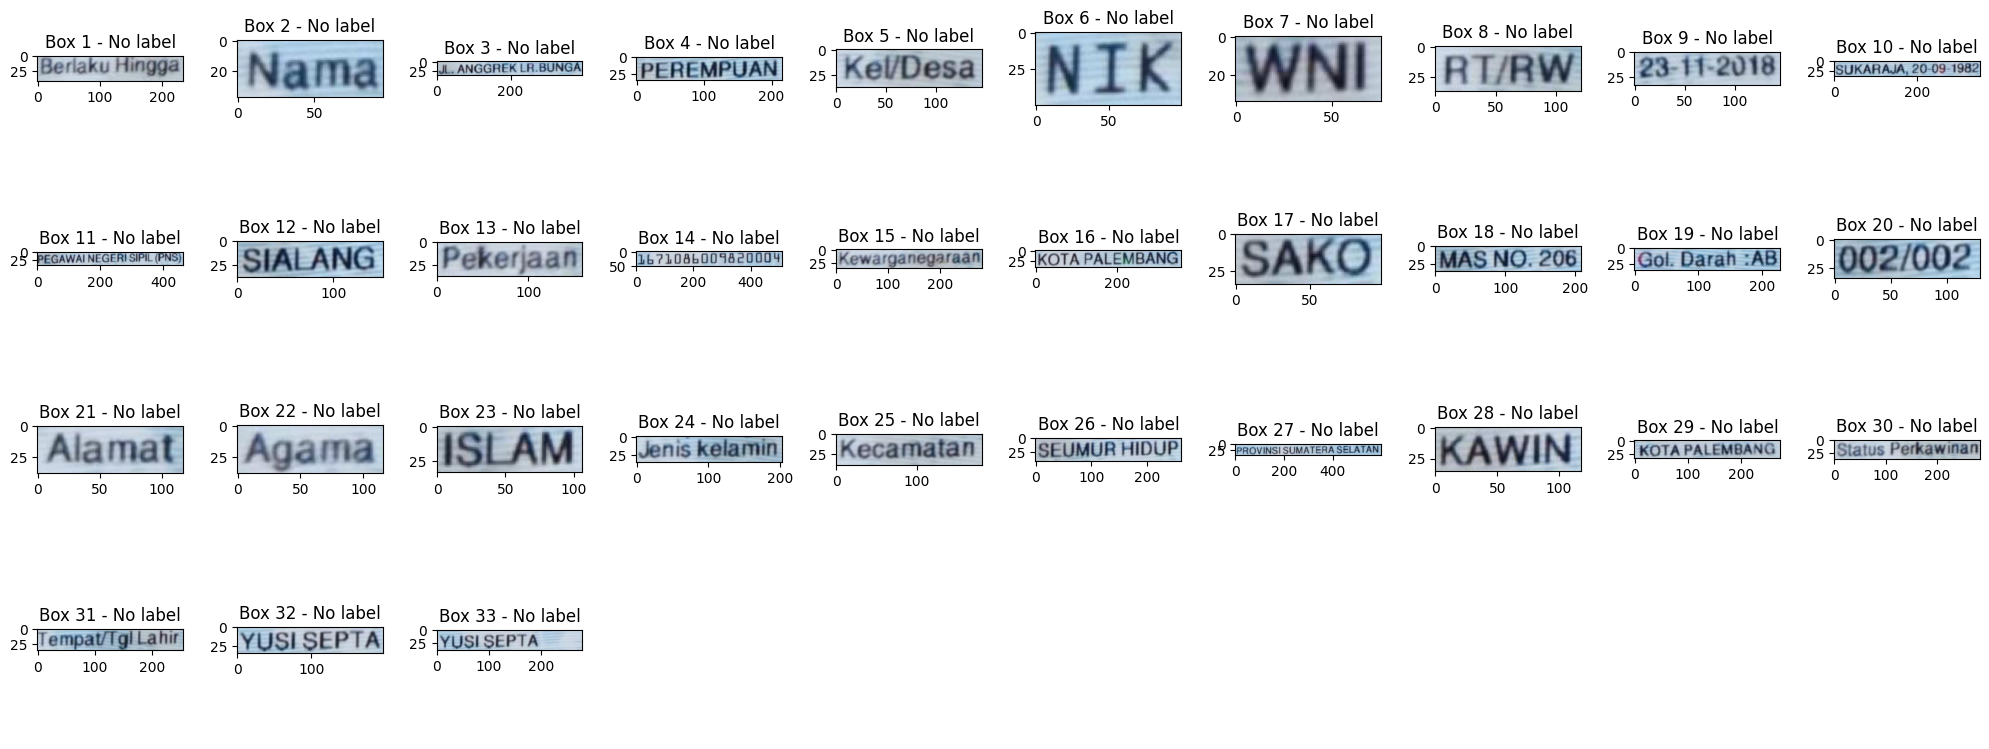

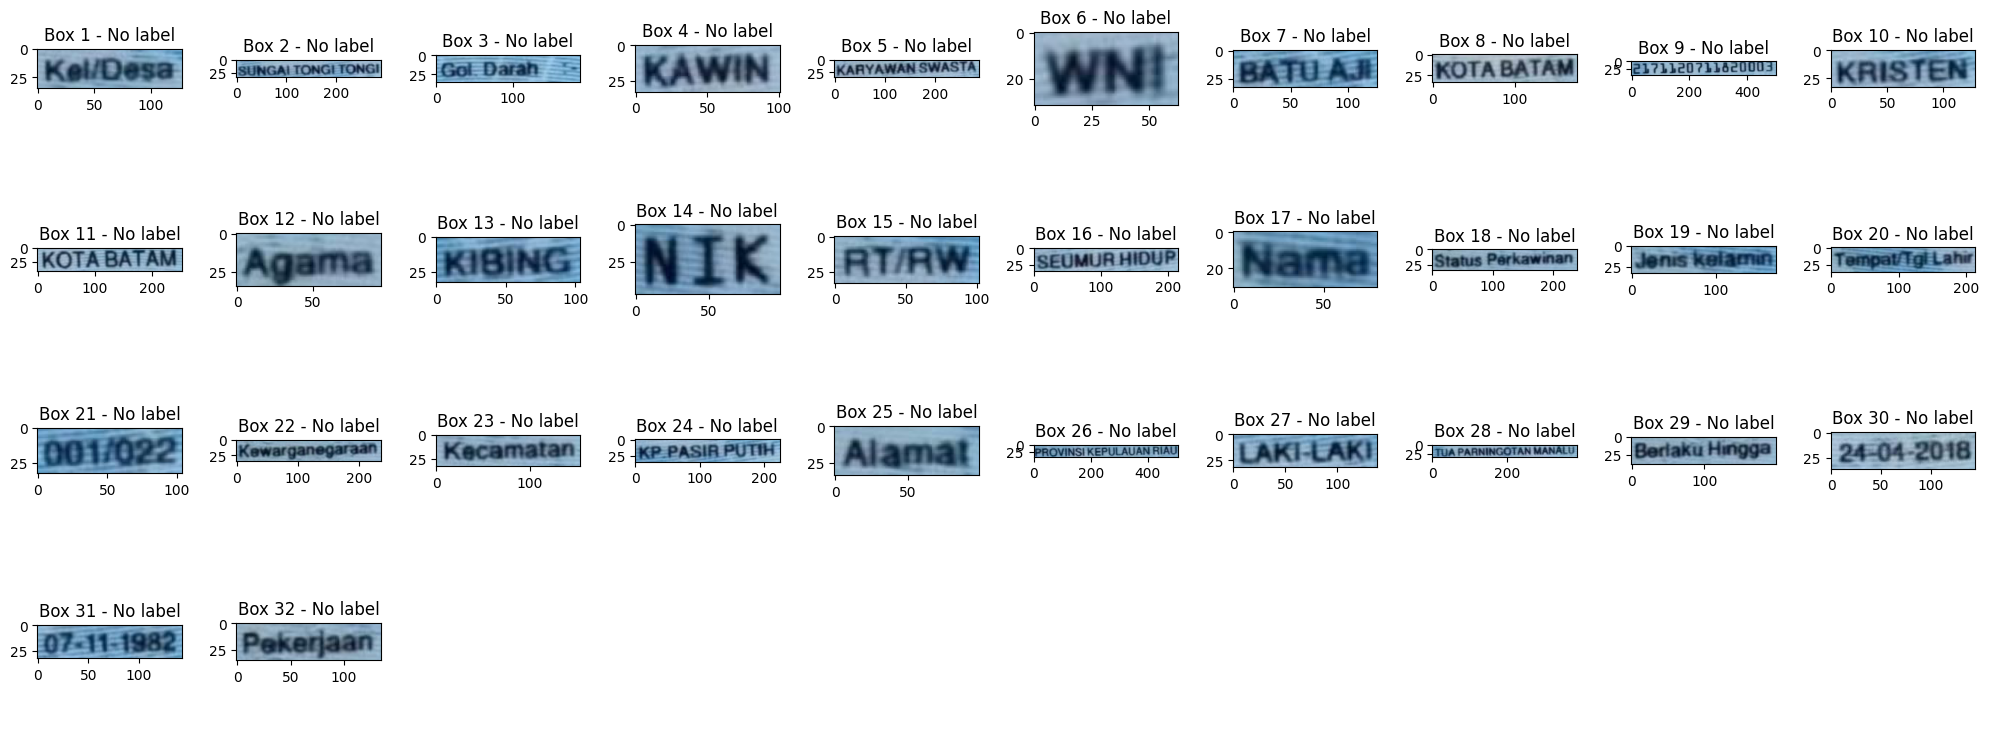

In [9]:
crop_images(auto_annotation_sample, "../data/cropped-images")